In [1]:
import os
import torch
import torch.nn as nn


from config import get_config
from data.loader import get_dataloaders
from models.model import create_model
from train_utils.resume import init_resume_state
from train_utils.resume import fill_trackers_from_history
from train_utils.train_epoch import train_one_epoch
from train_utils.evaluate import evaluate
from train_utils.train_metrics_logger import update_train_logs
from train_utils.train_metrics_logger import update_val_logs
from train_utils.checkpoint_saver import save_epoch_checkpoint
from train_utils.train_metrics_logger import record_and_save_epoch
from train_utils.early_stopping import check_early_stopping
from train_utils.training_summary import finalize_training_summary
from train_utils.training_summary import print_best_model_summary
from train_utils.plot_metrics import plot_train_val_metrics
from train_utils.plot_metrics import plot_loss_accuracy


In [2]:
# cfg=get_config(config_path="config/mamba_vision_bs512_ep50_lr1e-04_ds1000.yml")
cfg=get_config(config_path="config/efficientnet_bs512_ep50_lr1e-01_ds1000_sched-RLRP.yml")
# cfg=get_config()
print(cfg)

[INFO] Config Path: config/efficientnet_bs512_ep50_lr1e-01_ds1000_sched-RLRP.yml
[INFO] Detected native Ubuntu host: DS044955
[INFO] Using dataset root: /home/arsalan/Projects/110_JetscapeML/hm_jetscapeml_source/data/jet_ml_benchmark_config_01_to_09_alpha_0.2_0.3_0.4_q0_1.5_2.0_2.5_MMAT_MLBT_size_1000_balanced_unshuffled
[INFO] Detected dataset size: 1000
namespace(model_tag='EfficientNet', backbone='efficientnet', batch_size=512, epochs=50, learning_rate=0.1, patience=12, input_shape=(1, 32, 32), global_max=121.79151153564453, dataset_root_dir='/home/arsalan/Projects/110_JetscapeML/hm_jetscapeml_source/data/jet_ml_benchmark_config_01_to_09_alpha_0.2_0.3_0.4_q0_1.5_2.0_2.5_MMAT_MLBT_size_1000_balanced_unshuffled', train_csv='/home/arsalan/Projects/110_JetscapeML/hm_jetscapeml_source/data/jet_ml_benchmark_config_01_to_09_alpha_0.2_0.3_0.4_q0_1.5_2.0_2.5_MMAT_MLBT_size_1000_balanced_unshuffled/file_labels_train.csv', val_csv='/home/arsalan/Projects/110_JetscapeML/hm_jetscapeml_source/dat

In [3]:
os.makedirs(cfg.output_dir, exist_ok=True)
print(f"[INFO] Saving all outputs to: {cfg.output_dir}")

[INFO] Saving all outputs to: training_output/EfficientNet_bs512_ep50_lr1e-01_ds1000_g1_sched_ReduceLROnPlateau


In [4]:
# Set seed, device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"[INFO] Using device: {device}")
# torch.backends.cudnn.benchmark = True

[INFO] Using device: cuda


In [5]:
# Data
train_loader, val_loader, test_loader = get_dataloaders(cfg)

[INFO] Training samples: 796
[INFO] Validation samples: 96
[INFO] Test samples: 108
[INFO] Length of training dataloader: 2
[INFO] Length of validation dataloader: 1
[INFO] Length of test dataloader: 1


In [6]:
# Model and optimizer
model, optimizer = create_model(cfg.backbone, cfg.input_shape, cfg.learning_rate)
model.to(device)

MultiHeadClassifier(
  (backbone): EfficientNet(
    (conv_stem): Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNormAct2d(
      32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
      (drop): Identity()
      (act): SiLU(inplace=True)
    )
    (blocks): Sequential(
      (0): Sequential(
        (0): DepthwiseSeparableConv(
          (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (bn1): BatchNormAct2d(
            32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
            (drop): Identity()
            (act): SiLU(inplace=True)
          )
          (aa): Identity()
          (se): SqueezeExcite(
            (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (act1): SiLU(inplace=True)
            (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (gate): Sigmoid()
          )
          (con

In [7]:
# from torch.optim.lr_scheduler import ReduceLROnPlateau
# scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=4, verbose=True)

from torch.optim.lr_scheduler import ReduceLROnPlateau, StepLR, MultiStepLR, CosineAnnealingLR, ExponentialLR, OneCycleLR, CosineAnnealingWarmRestarts

# Create scheduler based on config
scheduler_type = cfg.scheduler['type']

if scheduler_type == "ReduceLROnPlateau":
    scheduler = ReduceLROnPlateau(
        optimizer,
        mode=cfg.scheduler.get("mode", "max"),
        factor=cfg.scheduler.get("factor", 0.5),
        patience=cfg.scheduler.get("patience", 4),
        verbose=cfg.scheduler.get("verbose", True),
        min_lr=cfg.scheduler.get("min_lr", 1e-6)
    )
elif scheduler_type == "StepLR":
    scheduler = StepLR(
        optimizer,
        step_size=cfg.scheduler.get("step_size", 10),
        gamma=cfg.scheduler.get("gamma", 0.1)
    )
elif scheduler_type == "MultiStepLR":
    scheduler = MultiStepLR(
        optimizer,
        milestones=cfg.scheduler.get("milestones", [30, 40]),
        gamma=cfg.scheduler.get("gamma", 0.1)
    )
elif scheduler_type == "CosineAnnealingLR":
    scheduler = CosineAnnealingLR(
        optimizer,
        T_max=cfg.scheduler.get("T_max", 50),
        eta_min=cfg.scheduler.get("min_lr", 0)
    )
elif scheduler_type == "CosineAnnealingWarmRestarts":
    scheduler = CosineAnnealingWarmRestarts(
        optimizer,
        T_0=cfg.scheduler.get("T_0", 10),
        T_mult=cfg.scheduler.get("T_mult", 2)
    )
elif scheduler_type == "ExponentialLR":
    scheduler = ExponentialLR(
        optimizer,
        gamma=cfg.scheduler.get("gamma", 0.95)
    )
elif scheduler_type == "OneCycleLR":
    scheduler = OneCycleLR(
        optimizer,
        max_lr=cfg.scheduler.get("max_lr", cfg.learning_rate),
        epochs=cfg.epochs,
        steps_per_epoch=len(train_loader)
    )
else:
    raise ValueError(f"Unsupported scheduler type: {scheduler_type}")


/home/arsalan/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [8]:
if torch.cuda.device_count() > 1:
    print(f"Using {torch.cuda.device_count()} GPUs")
    model = torch.nn.DataParallel(model)
else:
    print("Using single GPU")
    

Using single GPU


In [9]:
criterion = {
    # 'energy_loss_output': nn.BCELoss(),
    'energy_loss_output': nn.BCEWithLogitsLoss(),
    'alpha_output': nn.CrossEntropyLoss(),
    'q0_output': nn.CrossEntropyLoss()
}
print(f"[INFO] Loss functions:{criterion}")

[INFO] Loss functions:{'energy_loss_output': BCEWithLogitsLoss(), 'alpha_output': CrossEntropyLoss(), 'q0_output': CrossEntropyLoss()}


In [10]:
print(f"[INFO] Init Training Trackers")
train_loss_energy_list, train_loss_alpha_list, train_loss_q0_list, train_loss_list = [], [], [],[]
train_acc_energy_list, train_acc_alpha_list, train_acc_q0_list, train_acc_list = [], [], [], []

print(f"[INFO] Init Validation Trackers")
val_loss_energy_list, val_loss_alpha_list,val_loss_q0_list,val_loss_list = [], [], [], []
val_acc_energy_list, val_acc_alpha_list,val_acc_q0_list ,val_acc_list = [],[],[],[]

[INFO] Init Training Trackers
[INFO] Init Validation Trackers


In [11]:
model, optimizer, start_epoch, best_acc, early_stop_counter, best_epoch, best_metrics, training_summary, all_epoch_metrics,summary_status = init_resume_state( model, optimizer, device,cfg)

[INFO] Init Resume/Training Parameters
[INFO] Starting fresh training run by initializing training summary
[INFO] 📄 Training summary saved to: training_output/EfficientNet_bs512_ep50_lr1e-01_ds1000_g1_sched_ReduceLROnPlateau/training_summary.json


In [12]:
fill_trackers_from_history(
    all_epoch_metrics,
    train_loss_energy_list, train_loss_alpha_list, train_loss_q0_list, train_loss_list,
    train_acc_energy_list, train_acc_alpha_list, train_acc_q0_list, train_acc_list,
    val_loss_energy_list, val_loss_alpha_list, val_loss_q0_list, val_loss_list,
    val_acc_energy_list, val_acc_alpha_list, val_acc_q0_list, val_acc_list,
    summary_status, best_epoch
)

In [13]:
# for testing
# train_metrics = train_one_epoch(train_loader, model, criterion, optimizer, device)
# print(f"[INFO] Training metrics: {train_metrics}")

In [14]:
for epoch in range(start_epoch, cfg.epochs):
    print(f"[INFO] Epoch {epoch+1}/{cfg.epochs}")
    train_metrics={}
    train_metrics = train_one_epoch(train_loader, model, criterion, optimizer, device)
    (train_loss_list,
    train_loss_energy_list,
    train_loss_alpha_list,
    train_loss_q0_list,
    train_acc_list,
    train_acc_energy_list,
    train_acc_alpha_list,
    train_acc_q0_list
    ) = update_train_logs(
        train_metrics,
        train_loss_list,
        train_loss_energy_list,
        train_loss_alpha_list,
        train_loss_q0_list,
        train_acc_list,
        train_acc_energy_list,
        train_acc_alpha_list,
        train_acc_q0_list
    )
    val_metrics = evaluate(val_loader, model, criterion, device)
    (val_loss_list,
    val_loss_energy_list,
    val_loss_alpha_list,
    val_loss_q0_list,
    val_acc_list,
    val_acc_energy_list,
    val_acc_alpha_list,
    val_acc_q0_list,
    ) = update_val_logs(
        val_metrics,
        val_loss_list,
        val_loss_energy_list,
        val_loss_alpha_list,
        val_loss_q0_list,
        val_acc_list,
        val_acc_energy_list,
        val_acc_alpha_list,
        val_acc_q0_list,
    )
    print(f"[INFO] Epoch {epoch+1}: Energy Acc ={val_metrics['energy']['accuracy']:.4f}, αs Acc = {val_metrics['alpha']['accuracy']:.4f}, Q0 Acc = {val_metrics['q0']['accuracy']:.4f}, Total Acc = {val_metrics['accuracy']:.4f}")
    print(f"[INFO] Epoch {epoch+1}: Energy Loss ={val_metrics['loss_energy']:.4f}, αs Loss = {val_metrics['loss_alpha']:.4f}, Q0 Loss = {val_metrics['loss_q0']:.4f}, Total Loss = {val_metrics['loss']:.4f}")
    
    scheduler.step(val_metrics['accuracy'])  # or macro average accuracy if defined
    for param_group in optimizer.param_groups:
        current_lr = param_group['lr']
        print(f"📉 Current LR: {current_lr}")
    
    all_epoch_metrics=record_and_save_epoch(epoch, train_metrics, val_metrics, current_lr, all_epoch_metrics, cfg.output_dir)
    
    # save_epoch_checkpoint(
    #     epoch=epoch,
    #     model=model,
    #     optimizer=optimizer,
    #     metrics=val_metrics,
    #     output_dir=cfg.output_dir
    # )

    best_acc, best_metrics, best_epoch, early_stop_counter, should_stop = check_early_stopping(
        best_acc=best_acc,
        best_metrics=best_metrics,
        early_stop_counter=early_stop_counter,
        best_epoch=best_epoch,
        model=model,
        optimizer=optimizer,
        val_metrics=val_metrics,
        output_dir=cfg.output_dir,
        patience=cfg.patience,
        epoch=epoch
    )
    
    if should_stop:
        break
    
    print("="*150)
    

[INFO] Epoch 1/50


[INFO] Epoch 1: Energy Acc =0.7500, αs Acc = 0.3333, Q0 Acc = 0.2500, Total Acc = 0.0000
[INFO] Epoch 1: Energy Loss =21152304.0000, αs Loss = 41781828.0000, Q0 Loss = 121347616.0000, Total Loss = 184281744.0000
📉 Current LR: 0.1
[INFO] Epoch 1: Saving metrics to disk
💾 Last model saved at epoch 1
⏳ No improvement. Early stop counter: 1/12
[INFO] Epoch 2/50


[INFO] Epoch 2: Energy Acc =0.2500, αs Acc = 0.3333, Q0 Acc = 0.2500, Total Acc = 0.0000
[INFO] Epoch 2: Energy Loss =3288202.7500, αs Loss = 11466780.0000, Q0 Loss = 14900764.0000, Total Loss = 29655748.0000
📉 Current LR: 0.1
[INFO] Epoch 2: Saving metrics to disk


💾 Last model saved at epoch 2
⏳ No improvement. Early stop counter: 2/12
[INFO] Epoch 3/50


[INFO] Epoch 3: Energy Acc =0.7500, αs Acc = 0.3333, Q0 Acc = 0.2500, Total Acc = 0.0833
[INFO] Epoch 3: Energy Loss =6982911.5000, αs Loss = 14807713.0000, Q0 Loss = 66313728.0000, Total Loss = 88104352.0000
📉 Current LR: 0.1
[INFO] Epoch 3: Saving metrics to disk


💾 Last model saved at epoch 3
✅ Best model saved at epoch 3 with total accuracy: 0.0833
[INFO] Epoch 4/50


[INFO] Epoch 4: Energy Acc =0.7500, αs Acc = 0.3333, Q0 Acc = 0.2500, Total Acc = 0.0833
[INFO] Epoch 4: Energy Loss =1872308.3750, αs Loss = 2659399.7500, Q0 Loss = 4332933.5000, Total Loss = 8864642.0000
📉 Current LR: 0.1
[INFO] Epoch 4: Saving metrics to disk


💾 Last model saved at epoch 4
⏳ No improvement. Early stop counter: 1/12
[INFO] Epoch 5/50


[INFO] Epoch 5: Energy Acc =0.7500, αs Acc = 0.3333, Q0 Acc = 0.2500, Total Acc = 0.0000
[INFO] Epoch 5: Energy Loss =76654.6250, αs Loss = 93341.6875, Q0 Loss = 122225.5703, Total Loss = 292221.8750
📉 Current LR: 0.1
[INFO] Epoch 5: Saving metrics to disk


💾 Last model saved at epoch 5
⏳ No improvement. Early stop counter: 2/12
[INFO] Epoch 6/50


[INFO] Epoch 6: Energy Acc =0.7500, αs Acc = 0.3333, Q0 Acc = 0.2500, Total Acc = 0.0000
[INFO] Epoch 6: Energy Loss =4261.4365, αs Loss = 3364.4258, Q0 Loss = 8153.3062, Total Loss = 15779.1680
📉 Current LR: 0.1
[INFO] Epoch 6: Saving metrics to disk


💾 Last model saved at epoch 6
⏳ No improvement. Early stop counter: 3/12
[INFO] Epoch 7/50


[INFO] Epoch 7: Energy Acc =0.7500, αs Acc = 0.3333, Q0 Acc = 0.2500, Total Acc = 0.0833
[INFO] Epoch 7: Energy Loss =132.3445, αs Loss = 107.3034, Q0 Loss = 828.2142, Total Loss = 1067.8621
📉 Current LR: 0.1
[INFO] Epoch 7: Saving metrics to disk


💾 Last model saved at epoch 7
⏳ No improvement. Early stop counter: 4/12
[INFO] Epoch 8/50


[INFO] Epoch 8: Energy Acc =0.7500, αs Acc = 0.3333, Q0 Acc = 0.2500, Total Acc = 0.0833
[INFO] Epoch 8: Energy Loss =618.1203, αs Loss = 281.5317, Q0 Loss = 1617.5776, Total Loss = 2517.2295
📉 Current LR: 0.05
[INFO] Epoch 8: Saving metrics to disk


💾 Last model saved at epoch 8
⏳ No improvement. Early stop counter: 5/12
[INFO] Epoch 9/50


[INFO] Epoch 9: Energy Acc =0.7500, αs Acc = 0.3333, Q0 Acc = 0.2917, Total Acc = 0.0417
[INFO] Epoch 9: Energy Loss =9.1265, αs Loss = 7.0866, Q0 Loss = 20.7438, Total Loss = 36.9568
📉 Current LR: 0.05
[INFO] Epoch 9: Saving metrics to disk


💾 Last model saved at epoch 9
⏳ No improvement. Early stop counter: 6/12
[INFO] Epoch 10/50


[INFO] Epoch 10: Energy Acc =0.2500, αs Acc = 0.3333, Q0 Acc = 0.2500, Total Acc = 0.0000
[INFO] Epoch 10: Energy Loss =0.8725, αs Loss = 1.5302, Q0 Loss = 1.6699, Total Loss = 4.0726
📉 Current LR: 0.05
[INFO] Epoch 10: Saving metrics to disk


💾 Last model saved at epoch 10
⏳ No improvement. Early stop counter: 7/12
[INFO] Epoch 11/50


[INFO] Epoch 11: Energy Acc =0.7500, αs Acc = 0.3333, Q0 Acc = 0.2500, Total Acc = 0.0833
[INFO] Epoch 11: Energy Loss =0.6222, αs Loss = 1.2444, Q0 Loss = 2.3515, Total Loss = 4.2181
📉 Current LR: 0.05
[INFO] Epoch 11: Saving metrics to disk


💾 Last model saved at epoch 11
⏳ No improvement. Early stop counter: 8/12
[INFO] Epoch 12/50


[INFO] Epoch 12: Energy Acc =0.7500, αs Acc = 0.3333, Q0 Acc = 0.2500, Total Acc = 0.0833
[INFO] Epoch 12: Energy Loss =0.6006, αs Loss = 1.3702, Q0 Loss = 1.9411, Total Loss = 3.9118
📉 Current LR: 0.05
[INFO] Epoch 12: Saving metrics to disk


💾 Last model saved at epoch 12
⏳ No improvement. Early stop counter: 9/12
[INFO] Epoch 13/50


[INFO] Epoch 13: Energy Acc =0.7500, αs Acc = 0.3333, Q0 Acc = 0.2500, Total Acc = 0.0833
[INFO] Epoch 13: Energy Loss =0.6267, αs Loss = 1.6344, Q0 Loss = 1.4527, Total Loss = 3.7138
📉 Current LR: 0.025
[INFO] Epoch 13: Saving metrics to disk


💾 Last model saved at epoch 13
⏳ No improvement. Early stop counter: 10/12
[INFO] Epoch 14/50


[INFO] Epoch 14: Energy Acc =0.7500, αs Acc = 0.3333, Q0 Acc = 0.2500, Total Acc = 0.0833
[INFO] Epoch 14: Energy Loss =0.5862, αs Loss = 1.3739, Q0 Loss = 1.4502, Total Loss = 3.4104
📉 Current LR: 0.025
[INFO] Epoch 14: Saving metrics to disk


💾 Last model saved at epoch 14
⏳ No improvement. Early stop counter: 11/12
[INFO] Epoch 15/50


[INFO] Epoch 15: Energy Acc =0.7500, αs Acc = 0.3333, Q0 Acc = 0.2500, Total Acc = 0.0000
[INFO] Epoch 15: Energy Loss =0.5630, αs Loss = 1.1102, Q0 Loss = 1.4189, Total Loss = 3.0921
📉 Current LR: 0.025
[INFO] Epoch 15: Saving metrics to disk


💾 Last model saved at epoch 15
⏳ No improvement. Early stop counter: 12/12
🛑 Early stopping triggered at epoch 15. Best was at epoch 3.


In [15]:
finalize_training_summary(
    summary=training_summary,
    best_epoch=best_epoch,
    best_acc=best_acc,
    best_metrics=best_metrics,
    output_dir=cfg.output_dir
)
print_best_model_summary(
    best_epoch=best_epoch,
    best_acc=best_acc,
    best_metrics=best_metrics
)

[INFO] 📄 Training summary saved to: training_output/EfficientNet_bs512_ep50_lr1e-01_ds1000_g1_sched_ReduceLROnPlateau/training_summary.json

🏁 Best Model @ Epoch 3
Total Accuracy: 0.0833

🔹 ENERGY Task
  Accuracy : 0.7500
  Precision: 0.3750
  Recall   : 0.5000
  F1-Score : 0.4286

🔹 ALPHA Task
  Accuracy : 0.3333
  Precision: 0.1111
  Recall   : 0.3333
  F1-Score : 0.1667

🔹 Q0 Task
  Accuracy : 0.2500
  Precision: 0.0625
  Recall   : 0.2500
  F1-Score : 0.1000


📊 Plots saved to:
 - training_output/EfficientNet_bs512_ep50_lr1e-01_ds1000_g1_sched_ReduceLROnPlateau/loss_accuracy_plot.png
 - training_output/EfficientNet_bs512_ep50_lr1e-01_ds1000_g1_sched_ReduceLROnPlateau/loss_accuracy_plot.pdf


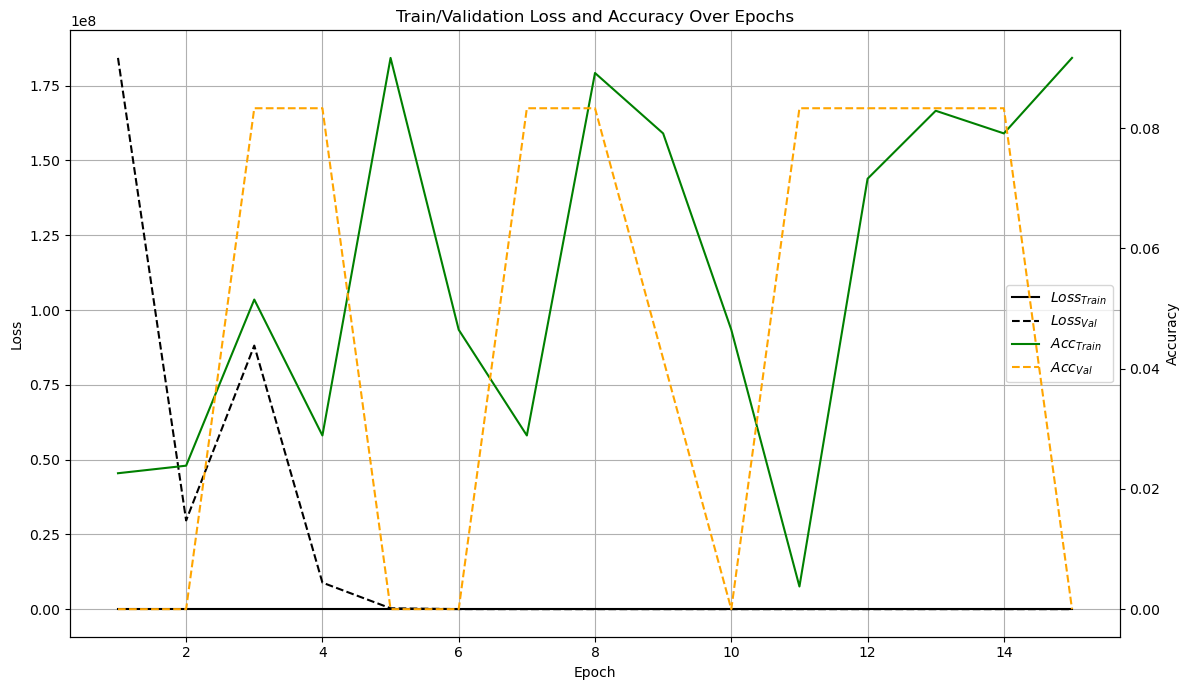

📉 Loss plot saved as:
  - training_output/EfficientNet_bs512_ep50_lr1e-01_ds1000_g1_sched_ReduceLROnPlateau/train_loss_and_accuracy_per_epoch_plot.png
  - training_output/EfficientNet_bs512_ep50_lr1e-01_ds1000_g1_sched_ReduceLROnPlateau/train_loss_and_accuracy_per_epoch_plot.pdf


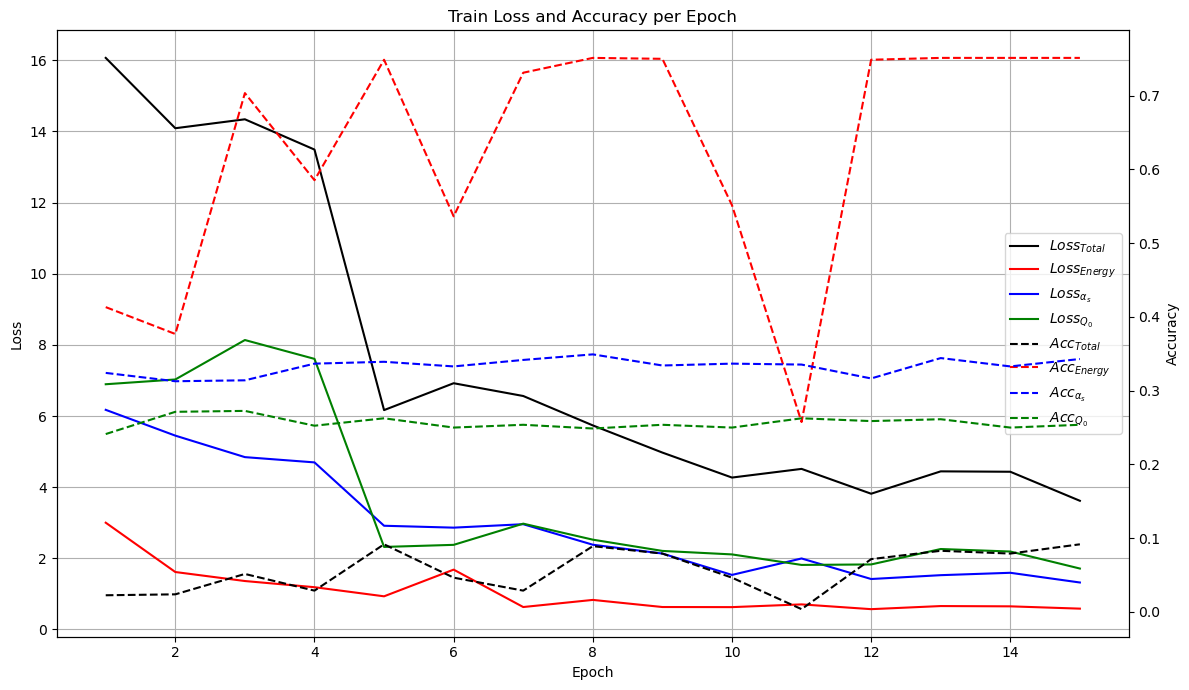

📉 Loss plot saved as:
  - training_output/EfficientNet_bs512_ep50_lr1e-01_ds1000_g1_sched_ReduceLROnPlateau/validation_loss_and_accuracy_per_epoch_plot.png
  - training_output/EfficientNet_bs512_ep50_lr1e-01_ds1000_g1_sched_ReduceLROnPlateau/validation_loss_and_accuracy_per_epoch_plot.pdf


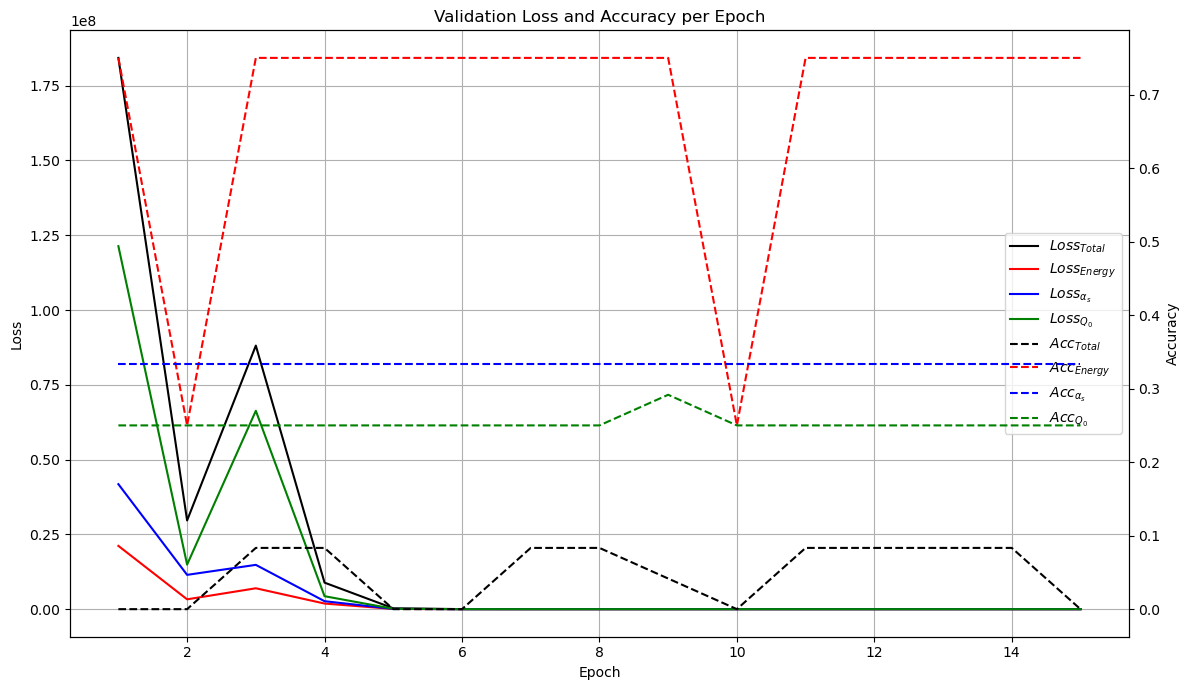

In [16]:
plot_train_val_metrics(train_loss_list, val_loss_list, train_acc_list, val_acc_list, cfg.output_dir)
plot_loss_accuracy(train_loss_list,
                    train_loss_energy_list,
                    train_loss_alpha_list,
                    train_loss_q0_list,
                    train_acc_list,
                    train_acc_energy_list,
                    train_acc_alpha_list,
                    train_acc_q0_list,
                    cfg.output_dir,
                    title="Train Loss and Accuracy per Epoch")
plot_loss_accuracy(val_loss_list,
                    val_loss_energy_list,
                    val_loss_alpha_list,
                    val_loss_q0_list,
                    val_acc_list,
                    val_acc_energy_list,
                    val_acc_alpha_list,
                    val_acc_q0_list,
                    cfg.output_dir,
                    title="Validation Loss and Accuracy per Epoch")